# Supervised Classification and Logistic Regression

### Machine Learning as an Optimization problem

We will investigate some gradient-based and proximal algorithms on the binary classification problems with logistic regression

### Reading the dataset

We will use LibSVM formatted data, meaning that each line of the file (i.e. each example) will have the form

<tt>class feature_number1:feature_value1 feature_number2:feature_value2 ... feature_number$n_i$:feature_value$n_i$ </tt>

You may read such a file using MLUtils's <a href="http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.util.MLUtils.loadLibSVMFile">`loadLibSVMFile`</a> routine on the supervised classification datasets below.

The elements of the produced RDD have the form of <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint">`LabeledPoints`</a> composed of a label `example.label` corresponding to the class (+1 or -1) and a feature vector `example.features` generally encoded as a <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector">`SparseVector`</a>.



In [4]:
# set up spark environment (using Spark local mode set to # cores on your machine)
from pyspark import SparkContext, SparkConf

conf = SparkConf()
conf.setMaster("local[*]")
conf.setAppName("MSIAM part II - Logistic Regression")

sc = SparkContext(conf = conf)

In [25]:
# path to LibSVM Datasets
from __future__ import division
LibSVMHomeDir="../data/LibSVM/"
# LibSVMHomeDir="02/data/LibSVM/"


LibName="ionosphere.txt"             # a small dataset to begin with
#LibName="rcv1_train.binary"          # a bigger one 

> Form an RDD from the selected dataset.

> Count the number of examples, features, the number of examples of class '+1' and the density of the dataset.

In [27]:
from pyspark.mllib.util import MLUtils
data = MLUtils.loadLibSVMFile(sc, LibSVMHomeDir + LibName).setName("LibSVM")
numExamples = data.count()
print("Number of examples : " + str(numExamples))

numFeatures = (data.first().features.size)
print("Number of features : " + str(numFeatures))

numPosExamples = data.filter(lambda x : x.label == 1).count()
print("Number of examples of class '+1' : " + str(numPosExamples))

numNegExamples = data.filter(lambda x : x.label == -1).count()
print("Number of examples of class '-1' : " + str(numNegExamples))

nonZeroFeatures = data.map(lambda x : x.features.numNonzeros()).sum()
print("Number of non-zero features : " + str(nonZeroFeatures))

print("Density : " + str(nonZeroFeatures/(numExamples*numFeatures)))

print("Dataset:")
print(data.first())

Number of examples : 351
Number of features : 34
Number of examples of class '+1' : 225
Number of examples of class '-1' : 126
Number of non-zero features : 10551
Density : 0.884112619407
Dataset:
(1.0,(34,[0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33],[1.0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.0376,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.3409,0.42267,-0.54487,0.18641,-0.453]))


### Preprocessing

An important first step for learning by regression is to preprocess the dataset. This processing usually consists in:
* Adding an intercept, that is an additional feature equal to one for all examples (statistically, this accounts for the fact that the two classes may be imbalanced).
* For the dense datasets:
    *  normalize to have zero-mean and unit variance for every feature (except the interecept for instance.
* For sparse datasets:
    * normalize so that the feature vector has unit $\ell_2$ norm for each example.

This does not really change the problem but it will ease the convergence of the applied optimization algorithms.




In [28]:
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
import numpy as np

label = data.map(lambda x: x.label)
features = data.map(lambda x: x.features)
scaler = StandardScaler(withMean=True, withStd=True)

normalizedFeatures = scaler.fit(features)

normalizedData = label.zip(normalizedFeatures.transform(features.map(lambda x: Vectors.dense(x.toArray()))))

numExamples = normalizedData.count()
print("Number of examples : " + str(numExamples))

numFeatures = (normalizedData.first()[1].size)
print("Number of features : " + str(numFeatures))

nonZeroFeatures = normalizedData.map(lambda x : x[1].numNonzeros()).sum()
print("Number of non-zero features : " + str(nonZeroFeatures))

print("Density : " + str(nonZeroFeatures/(numExamples*numFeatures)))

print(normalizedData.first())

# Add intercept
interceptedData = normalizedData.map(lambda x : (x[0], np.append(x[1],np.array([1], float))))

preprocessedData = interceptedData.map(lambda x : LabeledPoint(x[0], x[1]))
print("Now the data has the form:")
print(preprocessedData.first())

Number of examples : 351
Number of features : 34
Number of non-zero features : 11583
Density : 0.970588235294
(1.0, DenseVector([0.3479, 0.0, 0.7114, -0.2339, 0.4835, -0.2014, 0.5762, -0.9533, 0.9627, -0.2971, 0.6677, -0.6721, 0.3162, -1.097, 0.4001, -0.9891, 0.7469, -0.7686, 0.3556, -0.5739, 0.3821, -0.5887, 0.0116, -0.789, 0.2973, -0.8663, -0.2535, -0.713, -0.2879, -0.6162, 0.1228, -1.0535, -0.3118, -0.9982]))
Now the data has the form:
(1.0,[0.347936582539,0.0,0.711356868051,-0.233923299777,0.483517440274,-0.201447401018,0.576236183309,-0.953318232829,0.962699854308,-0.297086123228,0.667701472196,-0.67214779189,0.316221779651,-1.09697653583,0.400106799693,-0.989073611325,0.746918760863,-0.768583755912,0.355647777269,-0.573895241659,0.382098569801,-0.588683865907,0.0115681972685,-0.789002293191,0.297303247943,-0.866328217104,-0.253505647078,-0.712953447706,-0.287878698632,-0.616159183518,0.122761695704,-1.05354994462,-0.311775523591,-0.998169888876,1.0])


#  Initialization

We will set up here the variables, and the training versus testing dataset. Indeed, we will take a portion of the dataset to learn called the `learning set`, say $95$%, and we will test our predictions on the rest, the `testing set`.

In [29]:
train_test_split = preprocessedData.randomSplit(weights=[0.95, 0.05],seed=1)
trainRDD =   train_test_split[0]
testRDD = train_test_split[1]
print("Number of examples in training set : " + str(trainRDD.count()))

numPosExamples = trainRDD.filter(lambda x : x.label == 1).count()
print("Number of examples of class '+1' in training set : " + str(numPosExamples))

numNegExamples = trainRDD.filter(lambda x : x.label == -1).count()
print("Number of examples of class '-1' in training set : " + str(numNegExamples))

print("Number of examples in testing set : " + str(testRDD.count()))

numPosExamples = testRDD.filter(lambda x : x.label == 1).count()
print("Number of examples of class '+1' in testing set : " + str(numPosExamples))

numNegExamples = testRDD.filter(lambda x : x.label == -1).count()
print("Number of examples of class '-1' in testing set : " + str(numNegExamples))

Number of examples in training set : 332
Number of examples of class '+1' in training set : 212
Number of examples of class '-1' in training set : 120
Number of examples in testing set : 19
Number of examples of class '+1' in testing set : 13
Number of examples of class '-1' in testing set : 6


#  Minimization of the logistic loss with the Gradient algorithm

The goal of this section is to: 
1. Compute gradients of the loss functions.
2. Implement a Gradient algorithm.
3. Observe the prediction accuracy of the developed methods.

In [12]:
import math
def logistic_loss_per_example(example,x):
    """ Computes the logistic loss for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        real value: l 
    """
    loss = math.log(1 + math.exp((-example.label)*(np.dot(example.features,x))))
    return loss

In [30]:
def logistic_grad_per_example(example,x):
    """ Computes the logistic gradient for a Labeled point
    Args:
        example: a labeled point
        x: regressor
    Returns:
        numpy array: g 
    """
    exp = math.exp((example.label)*(np.dot(example.features,x)))
    grad = ((-example.label)/((1+exp)))*(example.features) 
    return grad
# x = [0.0 for i in range(numFeatures+1)]
# grad = trainRDD.map(lambda train : logistic_grad_per_example(train, x))
# print(grad.sum())

In [31]:
def grad_algo(trainRDD, GAMMA, MAX_ITER):
    f_tab = []
    x = [0.0 for i in range(numFeatures+1)]
    m = trainRDD.count()
    for i in range(MAX_ITER):
        loss = (1/m)*(trainRDD.map(lambda train : logistic_loss_per_example(train, x)).sum())
        f_tab.append(loss)
        grad = (1/m)*(trainRDD.map(lambda train : logistic_grad_per_example(train, x)).sum())
        x = x - GAMMA*(grad)
    f_tab.append((1/m)*(trainRDD.map(lambda train : logistic_loss_per_example(train, x)).sum()))
    return x, f_tab

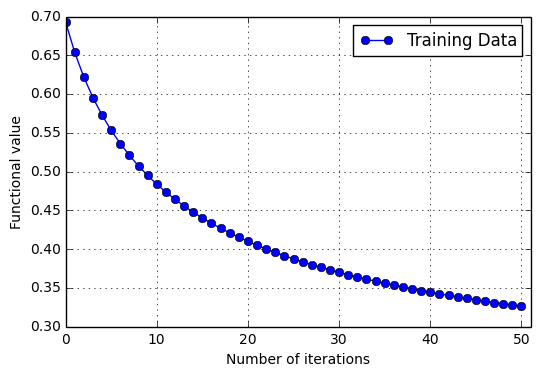

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline  
MAX_ITER = 50
step_size = 0.1
x_grad, f_tab = grad_algo(trainRDD, step_size, MAX_ITER)

plt.figure()
plt.plot(range(MAX_ITER+1), f_tab, marker='o', label='Training Data')
plt.xlim(0, MAX_ITER+1)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.legend()
plt.grid()
plt.show()



In [35]:
def prediction_accuracy(example, x):
    predicted_label = -1
    if (1/(1 + math.exp(-np.dot(example.features, x)))) > 0.5:
        predicted_label = +1
    product = predicted_label*example.label
    if (product > 0):
        return 1
    else:
        return 0

example = LabeledPoint(1.0, [2.0, 3.0])
x1 = np.array([0.5, 0.3])
#print(prediction_accuracy(example, x1))
#print(np.dot(example.features, x1))
def accuracy(rdd, x):
    accuracy = rdd.map(lambda example : prediction_accuracy(example, x))
    print("Accuracy on test data : " + str(int((accuracy.sum())/(accuracy.count())*100)) + "%")
    
accuracy(testRDD, x_grad)

# Step size = 0.1 -> accuracy - 89%
# Step size = 0.01 -> accuracy - 77%

Accuracy on test data : 89%


# Regularized logisitic regression

In addition to the loss, it is usual to add a regularization term of the form
$$ r(x) = \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2 $$

The first part promotes sparsity of the iterates while the second part prevents over-fitting. 
This kind of regularization is often called:
- *elastic-net* when $ \lambda_1$ and $ \lambda_2$ are non-null
- $\ell_1$ when $\lambda_2 = 0$
- *Tikhonov* when $\lambda_1 = 0$

The full optimization problems now writes
\begin{align*}
\min_{x\in\mathbb{R}^d } g(x) =  \frac{1}{m}  \sum_{i=1}^m  \log( 1+\exp(-b_i \langle a_i,x \rangle) ) +  \lambda_1 \|x\|_1 + \lambda_2 \|x\|^2_2
\end{align*}



In [41]:
def regularized_logistic_loss_per_example(example, x, lambda1, lambda2):
    loss = math.log(1 + math.exp((-example.label)*(np.dot(example.features,x)))) + lambda1*(np.linalg.norm(x,1)) + lambda2*((np.linalg.norm(x))**2)
    return loss

def regularized_logistic_grad_per_example(example, x, lambda2):
    exp = math.exp((example.label)*(np.dot(example.features,x)))
    grad = ((-example.label)*(1/(1+exp)))*(example.features) + np.multiply(2.0*lambda2,x)
    return grad

def n_prox(x, l):
    #np.multiply(np.sign(x), np.maximum(np.abs(x)- l,0))  
    #return np.array(list(map(lambda x: compare(x,l),x)))
    x_abs = np.abs(x)
    return np.sign(x) * (x_abs - l) * (x_abs > l)
    
def prox_enet(x, l_l1, l_l2, t=1.):
    """Proximal operator for the elastic net at x"""
    x_abs = np.abs(x)
    prox_l1 = np.sign(x) * (x_abs - t * l_l1) * (x_abs > t * l_l1)
    return prox_l1 / (1. + t * l_l2)



In [42]:
def prox_grad_algo(trainRDD, gamma, max_iter, lambda1, lambda2):
    f_tab = []
    mu, sigma = 0, 1
    x = np.random.normal(mu, sigma, numFeatures+1)#[0.0 for i in range(numFeatures+1)]
    m = trainRDD.count()
    print(x)
    for i in range(max_iter):
        #loss = (1/m)*(trainRDD.map(lambda train : regularized_logistic_loss_per_example(train, x, lambda1, lambda2)).sum())
        loss = (1/m)*(trainRDD.map(lambda train : logistic_loss_per_example(train, x)).sum())
        f_tab.append(loss)
        grad = (1/m)*(trainRDD.map(lambda train : regularized_logistic_grad_per_example(train, x, lambda2)).sum())
        #grad = (1/m)*(trainRDD.map(lambda train : logistic_grad_per_example(train, x)).sum())
        #print(grad)
        x = n_prox(x - gamma * grad, 0.0002)
        #x = prox_enet(x - gamma * grad, lambda1, lambda2)
        #print(x)
    #f_tab.append((1/m)*(trainRDD.map(lambda train : regularized_logistic_loss_per_example(train, x, lambda1, lambda2)).sum()))
    f_tab.append((1/m)*(trainRDD.map(lambda train : logistic_loss_per_example(train, x)).sum()))
    return x, f_tab

In [39]:
lipschitz_constant = 0.25 * (trainRDD.map(lambda train : np.linalg.norm(train.features)**2).max())
print(lipschitz_constant)

33.3583797795


gamma : 0.0297988164676
[-1.04632576  0.75991129 -0.12028079  0.0707572  -1.69079547  1.03298062
 -0.15360037  0.42788981 -0.19799121  1.32524835  0.83880368  0.65323466
  1.22833202  1.50891749  0.38969403  0.34933743  0.52283749 -1.73935677
  0.18154092 -0.13026815  0.47502758  1.09110149  0.92550124 -0.63900135
 -0.28252043 -1.22144897  0.0518191  -1.8747755   1.68505171 -1.19577679
  0.84141994 -1.38568645 -0.52742771 -0.72660182  1.45390201]
[ 0.32651667  0.09210529  0.31554394  0.14792441  0.15403286  0.25295
  0.21320807  0.25187049  0.09693721  0.17074336  0.07330102  0.12850392
  0.10738427  0.2385963   0.06220926  0.07636354 -0.01240631  0.01846594
  0.03566423  0.00213562  0.14482988 -0.12171668  0.18626376  0.
  0.04238931  0.04228171 -0.2228986  -0.06191892  0.19188307 -0.0021081
  0.16473974 -0.06681393 -0.06519743 -0.15760156  0.33892757]


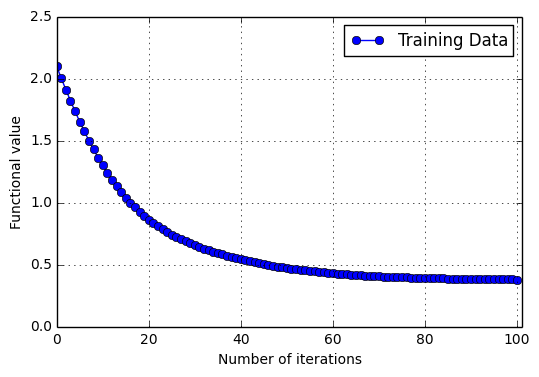

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline  

lambda1 = 0.1
lambda2 = 0.1
L_b = lipschitz_constant + 2*lambda1
gamma = 1/L_b
print("gamma : " + str(gamma))
max_iter = 100
step_size = 0.1

x, f_tab = prox_grad_algo(trainRDD, step_size, max_iter, lambda1, lambda2)
print(x)
plt.figure()
plt.plot(range(max_iter+1), f_tab, marker='o', label='Training Data')
plt.xlim(0, max_iter+1)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.legend()
plt.grid()
plt.show()

In [45]:
def prediction_accuracy(example, x):
    predicted_label = -1
    if (1/(1 + math.exp(-np.dot(example.features, x)))) > 0.5:
        predicted_label = +1
    product = predicted_label*example.label
    if (product > 0):
        return 1
    else:
        return 0

# example = LabeledPoint(1.0, [2.0, 3.0])
# x1 = np.array([0.5, 0.3])
#print(prediction_accuracy(example, x1))
#print(np.dot(example.features, x1))
def accuracy(rdd, x):
    accuracy = rdd.map(lambda example : prediction_accuracy(example, x))
    print("Accuracy on training data : " + str(((accuracy.sum())/(accuracy.count()))*100))
    
accuracy(trainRDD, x)

# Accuracy 89.6 lambda1 0.0 lambda2 0.2 stepSize 0.1 iterations 100
# Accuracy 86.3 lambda1 0.0 lambda2 0.2 stepSize 0.1 iterations 100
# Accuracy 81.1 lambda1 1.0 lambda2 0.0 stepSize 0.1 iterations 100
# Accuracy 88.4 lambda1 0.5 lambda2 0.5 stepSize 0.1 iterations 100
# Accuracy 89.3 lambda1 0.1 lambda2 0.1 stepSize 0.1 iterations 100

Accuracy on training data : 88.8554216867


gamma : 0.0297988164676
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[  2.25635335e+00   0.00000000e+00   9.29238225e-01   2.78034271e-01
   1.06788404e+00   7.87711887e-01   5.90952420e-01   1.00773205e+00
   3.88982129e-01   3.28444659e-01  -4.50583558e-01   2.23144087e-02
  -1.63775368e-01   3.97693873e-01   2.31246389e-01  -5.30046474e-01
  -6.99065016e-04   7.39492491e-01  -2.12581868e-01   1.48452835e-01
   2.86877697e-01  -1.48996782e+00   8.37911375e-01   3.21256468e-01
   7.84240185e-01   4.72512257e-01  -1.51674006e+00   1.76678607e-03
   2.35702387e-01   7.79520424e-01   8.38097287e-01  -2.75347197e-01
  -3.78737225e-01  -1.02225989e+00   1.92672880e-01]


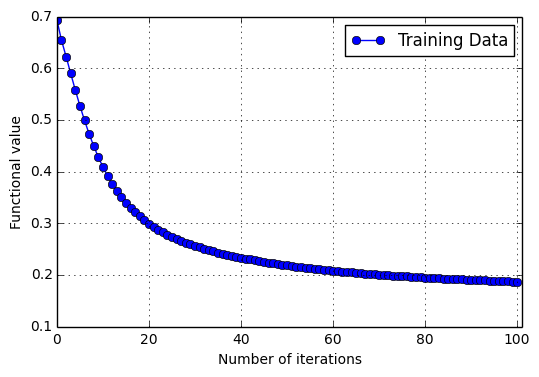

In [46]:
def soft_threshod(w,mu):
    return np.multiply(np.sign(w), np.maximum(np.abs(w)- mu,0))  

def fista_algo(trainRDD, gamma, max_iter, lambda1, lambda2):
    f_tab = []
    mu, sigma = 0, 1
    w = [0.0 for i in range(numFeatures+1)]
    v = w
    m = trainRDD.count()
    print(v)
    t = 0.0
    for i in range(0, max_iter):
        #loss = (1/m)*(trainRDD.map(lambda train : regularized_logistic_loss_per_example(train, w, lambda1, lambda2)).sum())
        loss = (1/m)*(trainRDD.map(lambda train : logistic_loss_per_example(train, w)).sum())
        f_tab.append(loss)
        w_prev = w
        #grad = (1/m)*(trainRDD.map(lambda train : regularized_logistic_grad_per_example(train, v, lambda2)).sum())
        grad = (1/m)*(trainRDD.map(lambda train : logistic_grad_per_example(train, v)).sum())        
        #print(grad)
        #t_new = (1 + math.sqrt(1+4*(t**2)))/2
        #alpha = (t-1)/t_new
        #t = t_new
        w = v - gamma * grad
        w = soft_threshod(w,0.001 * gamma)
        v = w + (i/(i+3)) * (w - w_prev)

    #f_tab.append((1/m)*(trainRDD.map(lambda train : regularized_logistic_loss_per_example(train, v, lambda1, lambda2)).sum()))
    f_tab.append((1/m)*(trainRDD.map(lambda train : logistic_loss_per_example(train, v)).sum()))
    return v, f_tab

import matplotlib.pyplot as plt
%matplotlib inline  

lambda1 = 0.1
lambda2 = 0.0
L_b = lipschitz_constant + 2*lambda1
gamma = 1/L_b
print("gamma : " + str(gamma))
max_iter = 100
step_size = 0.1

x, f_tab = fista_algo(trainRDD, step_size, max_iter, lambda1, lambda2)
print(x)
plt.figure()
plt.plot(range(max_iter+1), f_tab, marker='o', label='Training Data')
plt.xlim(0, max_iter+1)
plt.xlabel('Number of iterations')
plt.ylabel('Functional value')
plt.legend()
plt.grid()
plt.show()

<small><i>Examples taken from the course [Convex and Distributed Optimization](http://www.iutzeler.org/CDO/) (2016).</i></small>